In [1]:
# Imports
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import torch
from generator_training_test import generator
from rocket_deepl.module import *
from rocket_deepl.core.activations.relu import *
from rocket_deepl.core.activations.tanh import *
from rocket_deepl.core.layers import *
from rocket_deepl.sequential import *
from rocket_deepl.utils import *
from torch import cat

## Dataset and initialization

In [2]:
def plot_scores(param, paramName, tr_scores, va_scores, log_scale=False):
    plt.figure(figsize=(7, 5))
    plt.grid()
    plt.plot(param, tr_scores)
    plt.plot(param, va_scores)
    plt.legend(['train', 'validation'])
    plt.xlabel(paramName)
    plt.ylabel('Accuracy')
    if log_scale:
        plt.xscale('log')
        

# generate the dataset
X_train, y_train = generator(1000)
X_test, y_test = generator(1000)
y_train = y_train*2-1
y_test = y_test*2-1

# dataset baselines
X_train_baselines = X_train.numpy()
X_test_baselines = X_test.numpy()
y_train_baselines = (y_train == 1)[:, 1].numpy()
y_test_baselines = (y_test == 1)[:, 1].numpy()


X_train.data = (X_train - X_train.mean())/X_train.std() 
X_test.data = (X_test - X_test.mean())/X_test.std() 

X_all = cat((X_train, X_test), 0)
y_all = cat((y_train, y_test), 0)

## Baselines: Parameters Tuning

### Logistic regression

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Best lambda: 37.92690190732246
Test score: 0.501


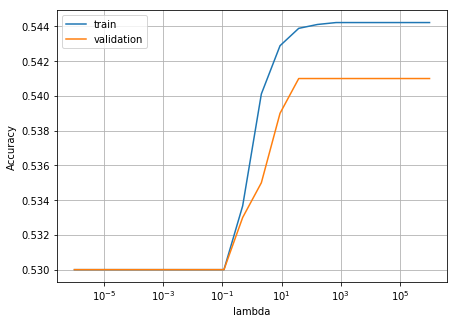

In [3]:
lambdas = np.logspace(-6, 6, 20) # grid search on a parameter of the model

# scores obtained with the different lambdas
logreg = {
    "tr_scores": [],
    "va_scores": []
}

for lambda_ in lambdas:
    result = cross_validate(LogisticRegression(C=lambda_), X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    logreg["tr_scores"].append(np.mean(result["train_score"]))
    logreg["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(lambdas, "lambda", logreg["tr_scores"], logreg["va_scores"], log_scale=True)

best_lambda = lambdas[np.argmax(logreg["va_scores"])]
print('Best lambda:', best_lambda)
print('Test score:', 
      LogisticRegression(C=best_lambda)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

### Random Forest

Best depth: 15
Test score: 0.967


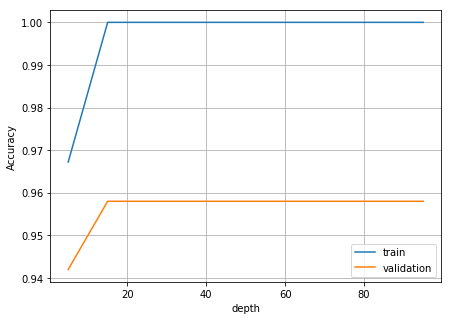

In [4]:
depths = np.arange(5, 100, 10) # grid search on a parameter of the model

# here we store all the scores obtained with the different depths
randForest = {
    "tr_scores": [],
    "va_scores": []
}

for depth in depths:
    result = cross_validate(
        RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1), 
        X_train_baselines, y_train_baselines, cv=10, return_train_score=True)
    
    randForest["tr_scores"].append(np.mean(result["train_score"]))
    randForest["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(depths, "depth", randForest["tr_scores"], randForest["va_scores"], log_scale=False)

best_depth = depths[np.argmax(randForest["va_scores"])]
print('Best depth:', best_depth)
print('Test score:',
      RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1)
      .fit(X_train_baselines, y_train_baselines)
      .score(X_test_baselines, y_test_baselines))

## Models Comparison

### Cross validation for RocketDeepL Sequential model

In [8]:
from sklearn.model_selection import KFold

def reset_sq(self):
        for module in self.modules:
            if isinstance(module, Linear):
                module.reset()

def cross_validate_sq(self, X, y, batch_size=2, n_splits=4, epochs=250, verbose=False):
        """ Run cross validation on the model and return the obtained test and train scores. """

        kf = KFold(n_splits=n_splits, random_state=1, shuffle=True)
        tr_scores = []
        va_scores = []

        result = {
            "train_score": [],
            "test_score" : []
        }

        split_n = 1
        for tr_indices, va_indices in kf.split(X):
            if verbose:
                print("----------------- fold " + str(split_n) + "/" + str(n_splits) + " -----------------")
            tr_indices = tr_indices.tolist()
            va_indices = va_indices.tolist()
            X_tr, y_tr = X[tr_indices], y[tr_indices]
            X_te, y_te = X[va_indices], y[va_indices]

            reset_sq(self)
            train_model(self, X_tr, y_tr, epochs, batch_size)

            number = compute_nb_errors(model, X_te, y_te, batch_size)
            number_of_misprediction = number

            # compute accuracy
            accuracy = (1 - number/y_te.size(0))
            result["test_score"].append(accuracy)

            split_n = split_n + 1

        return result

## Take class model from project 1 to implement Pytorch NN

In [9]:
"""
CODE FROM PROJECT1
"""
import torch
from torch import nn
from torch import optim

from matplotlib.pylab import plt

##################### MODEL CLASS #####################
class Model(nn.Module):
    """
    Abstract class to implement model.
    """

    def __init__(self):
        """
        Initialize function for model and history.
        """
        super(Model, self).__init__()
        self.history = History()

    def fit(self, train_input, train_target, test_input = None, test_target = None, epochs = 25, batch_size=25, doPrint=True):
        """
        Fit the model on the training data.
        Inputs:
            train_input: train data
            train_target: train target data
            test_input: test data if any
            test_target: test target data if any
            epochs: number of epochs,
            batch_size: size of the batch,
            doPrint: bool (if true it prints the epochs with loss and accuracy)
        """

        # Iniziale Print to print accuracy and loss for each epoch
        if doPrint:
            p = Print(self)

        def get_loss_accuracy(input_, target):
            """
            Function to get the loss and accuracy. Given the input and target.
            """
            predicted = self(input_) # get predicted (forward method in each subclass model)
            loss = self.criterion(predicted, target) # apply loss (i.e. MSE)
            accuracy = self.compute_accuracy(predicted, target) # compute accuracy
            return loss, accuracy

        for e in range(1, epochs + 1):

            # shuffle the train set to select different batches at each epoch
            indices_shuffled = torch.randperm(train_input.shape[0]) # random permutation of integers from 0 to train_input.shape[0] - 1.
            train_input = train_input[indices_shuffled]

            # shuffle target set according to indices_shuffled
            if isinstance(train_target, tuple): # bool, digit1, digit2 -> take corresponding in each target
                train_target = tuple(t[indices_shuffled] for t in train_target)
            else:
                train_target = train_target[indices_shuffled] # no auxiliary loss then just bool

            # iterate over the batches
            train_loss = 0
            train_acc = 0
            n_batches = 0
            for batch_start in range(0, train_input.shape[0], batch_size):
                n_batches += 1
                # get the current batch from the trainset
                batch_end = batch_start + batch_size
                train_input_batch = train_input[batch_start:batch_end]
                if isinstance(train_target, tuple): # we are using an auxiliary loss -> target is a tuple
                    train_target_batch = tuple(t[batch_start:batch_end] for t in train_target)
                else: # no auxiliary loss -> target is not a tuple
                    train_target_batch = train_target[batch_start:batch_end]

                # set gradients to zero before train step
                self.optimizer.zero_grad()

                # call forward method of subclass inside get_loss_accuracy method to get predicted value
                train_loss_batch, train_acc_batch = get_loss_accuracy(train_input_batch, train_target_batch)
                train_loss += train_loss_batch.item()
                train_acc += train_acc_batch

                train_loss_batch.backward() # backward propagation of gradients
                self.optimizer.step() # update parameters of optimizer

            # do the average across batches
            train_loss /= n_batches
            train_acc /= n_batches

            # Train loss and accuracy have been computed before the train step, test loss and accuracy after it
            test_acc = None
            test_loss = None

            # If we have the test compute loss and accuracy and overwrite test_acc and test_loss
            if test_input is not None:
                test_loss, test_acc = get_loss_accuracy(test_input, test_target)
                test_loss = test_loss.item()

            # add epoch to history saving new values
            self.history.epoch(
                train_loss=train_loss, train_acc=train_acc,
                test_loss=test_loss, test_acc=test_acc
            )

            # print accuracy and loss for each epoch
            if doPrint:
                p()

        return self

    def get_accuracy_train(self):
        # just get the last accuracy of the train
        return self.history.get_accuracies_train()[-1]

    def get_accuracy_test(self):
        # just get the last accuracy of the test
        return self.history.get_accuracies_test()[-1]

    def plot_history(self):
        """
        Plots loss and accuracies.
        """
        self.history.plot_losses()
        plt.plot()
        self.history.plot_accuracies()
        plt.plot()
        plt.show()

    def compute_accuracy(self, y_pred, y_target):
        """
        Function to compute accuracy.
        """
        y_pred = y_pred.clone()
        y_pred[y_pred>0.5] = 1
        y_pred[y_pred<=0.5] = 0
        acc = 100 * ((y_pred == y_target).sum().type(torch.FloatTensor).item())
        n = y_pred.shape[0]
        return acc / n # normalize by divide by length (1000) -> same as mean

    def number_params(self, module=None):
        """
        Return the number of parameters of the model.
        """
        if module is None:
            module = self # parameters of model

        # p.numel() returns #entries (#parameters that define tensor p)
        # p.requires_grad = p is part of neural network
        return sum(p.numel() for p in module.parameters() if p.requires_grad)

##################### HISTORY CLASS #####################

class History():
    """
    Handle history of loss during training.
    """
    def __init__(self):
        """
        Initialize the history (losses, epochs, accuracies of train and test)
        """
        self.epochs = 0
        self.train_losses = []
        self.train_acc = []
        self.test_losses = []
        self.test_acc = []

    def epoch(self, train_loss, train_acc, test_loss=None, test_acc=None):
        """
        Add a new epoch and update all values. This method is called at the end of each epoch from the model.
        """
        self.epochs += 1
        self.train_losses.append(train_loss)
        self.train_acc.append(train_acc)
        self.test_losses.append(test_loss)
        self.test_acc.append(test_acc)

    def plot_general(self, val1, val2, text1, text2, legend, isAccuracy=False):
        """
        General function to plot using matplotlib.
        """
        epochs_range = list(range(1, self.epochs + 1))

        ax = plt.figure(figsize=(7, 5)).gca() # gca = create current axes instance on the current figure

        ax.plot(epochs_range, val1, label=text1) # epochs
        ax.plot(epochs_range, val2, label=text2) # accuracy or loss depend on legend

        ax.grid()
        ax.set_xlabel("epochs", fontsize = 16)
        ax.set_ylabel(legend, fontsize = 16)

        if isAccuracy:
            ax.set_ylim((0, 100)) # accuracy is between 0 and 100

        ax.legend(fontsize = 13)


    def plot_losses(self):
        """
        Plot losses of train and test.
        """
        self.plot_general(self.test_losses, self.train_losses, 'Test loss', 'Train loss', 'loss', False)

    def plot_accuracies(self):
        """
        Plot accuracies of train and test.
        """
        self.plot_general(self.test_acc, self.train_acc, 'Test accuracy', 'Train accuracy', 'accuracy', True)

    # Getter function for accuracies
    def get_accuracies_train(self):
        return self.train_acc

    def get_accuracies_test(self):
        return self.test_acc

################################### PRINT CLASS ###################################
class Print():
    """
    Pring accuracy and loss during training for each epoch.
    """

    def __init__(self, model):
        self.model = model
        self.curr_epoch = self.model.history.epochs # epochs is updated time by time

        # set colors and style for print
        self.style = {
            'PURPLE': '\033[95m',
            'GREEN': '\033[92m',
            'RED': '\033[91m',
            'BOLD': '\033[1m',
            'END': '\033[0m',
        }

        # Print header
        print("{BOLD}{:^10}{END} | {BOLD}{:^25}{END} | {BOLD}{:^25}{END}".format('Epoch', 'Train loss - Accuracy', 'Dev. loss - Accuracy', **self.style))

    # Called every time we do p() -> then for each epoch
    def __call__(self):
        # get hisory
        h = self.model.history

        # compute #epoch
        epoch = str(h.epochs)

        # get last loss of train and test
        train_loss = h.train_losses[-1]
        test_loss =  h.test_losses[-1]

        # get last accuracies
        train_accuracy = h.train_acc[-1]
        test_accuracy = h.test_acc[-1]

        print(
            "{PURPLE}{:^10}{END} | {RED}{:^25}{END} | {GREEN}{:^25}{END}".format(
                epoch, # purple
                '{:5.4f} - {:3.2f}%'.format(train_loss, train_accuracy), # red
                'na - na' if test_loss is None else '{:5.4f} - {:3.2f}%'.format(test_loss, test_accuracy), # green
                **self.style
            )
        )


### Implement same model in Pytorch

In [10]:
# Model in pytorch
class Net(Model):

    def __init__(self, optimizer = optim.Adam, criterion = nn.MSELoss):
        super(Net, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 25),
            nn.ReLU(),
            nn.Linear(25, 25),
            nn.ReLU(),
            nn.Linear(25, 25),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(25, 2),
            nn.Tanh()
        )

        self.optimizer = optimizer(self.parameters())
        self.criterion = criterion()

    def forward(self, x):
        # Max pooling over a (2, 2) window
        features = self.feature_extractor(x)

        # classify >=
        pred = self.classifier(features)
        return pred

### Cross validation for pytorch

In [11]:
# Cross validation for model pytorch
from sklearn.model_selection import KFold

"""
This file use library that are not allowed for this project such as sklearn. We have used this file just to do a cross validation
in order to show results in our report.
"""
def cross_validate_pytorch(model, X, y, n_splits=4, epochs=250, batch_size=2):
        """ Run cross validation on the model and return the obtained test and train scores. """

        kf = KFold(n_splits=n_splits, random_state=1, shuffle=True)
        tr_scores = []
        va_scores = []

        result = {
            "train_score": [],
            "test_score" : []
        }
        
        split_n = 1
        for tr_indices, va_indices in kf.split(X):
            tr_indices = tr_indices.tolist()
            va_indices = va_indices.tolist()
            X_tr, y_tr = X[tr_indices], y[tr_indices]
            X_te, y_te = X[va_indices], y[va_indices]
            
            model.fit(
                X_tr, y_tr,
                X_te, y_te,
                epochs=epochs,
                batch_size=batch_size,
                doPrint=False
            )

            # compute accuray
            result["train_score"].append(model.get_accuracy_train())
            result["test_score"].append(model.get_accuracy_test())

            split_n = split_n + 1

        return result 

## Execute cross validation on all models

In [37]:
logreg = LogisticRegression(C=best_lambda)
randforest = RandomForestClassifier(n_estimators=100, max_depth=best_depth, n_jobs=-1, random_state=1)
knn = KNeighborsClassifier(n_neighbors=best_k)
net = Net()

# model: as the one in test.py
model = Sequential([
    Linear(2, 25), ReLU(),
    Linear(25,25), ReLU(),
    Linear(25,25), ReLU(),
    Linear(25,25), ReLU(),
    Linear(25, 2), tanH()
])

print("Running cross validation on Logistic Regression...")
logreg_scores = cross_validate(
   logreg,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=False)

print("Running cross validation on Random Forest...")
randforest_scores = cross_validate(
   randforest,
   X_train_baselines, y_train_baselines, cv=10, return_train_score=False)

print("Running cross validation on the Pytorch model...")
pytorch_scores = cross_validate_pytorch(net, X_all, y_all, n_splits=4)

print("Running cross validation on the Sequential Module...")
sequential_scores = cross_validate_sq(model, X_all, y_all, batch_size=2, epochs=250, verbose=False, n_splits=4)

print("Done!")

Running cross validation on Logistic Regression...
Running cross validation on Random Forest...
Running cross validation on the Pytorch model...
Running cross validation on the Sequential Module...
Done!


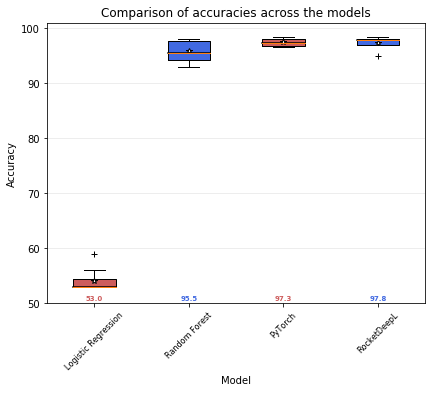

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

model_scores = [
   logreg_scores["test_score"]*100,
   randforest_scores["test_score"]*100,
   pytorch_scores["test_score"]*100,
   np.array(sequential_scores["test_score"])*100
]

randomDists = ["Logistic Regression", "Random Forest", "PyTorch",
               "RocketDeepL"]

data = model_scores

fig, ax1 = plt.subplots(figsize=(6, 6))
fig.canvas.set_window_title('Boxplots')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
ax1.set_title('Comparison of accuracies across the models')
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy')

numBoxes = 4

# Now fill the boxes with desired colors
boxColors = ['indianred', 'royalblue']
medians = list(range(numBoxes))
for i in range(numBoxes):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(4):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = np.column_stack([boxX, boxY])
    # Alternate between Dark Khaki and Royal Blue
    k = i % 2
    boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        ax1.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
    ax1.plot([np.average(med.get_xdata())], [np.average(data[i])],
             color='w', marker='*', markeredgecolor='k')

# Set the axes ranges and axes labels
ax1.set_xlim(0.5, 4 + 0.5)
top = 101
bottom = 50
ax1.set_ylim(bottom, top)
ax1.set_xticklabels(randomDists,
                    rotation=45, fontsize=8)

# Due to the Y-axis scale being different across samples, it can be
# hard to compare differences in medians across the samples. Add upper
# X-axis tick labels with the sample medians to aid in comparison
# (just use two decimal places of precision)
pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top - (top*0.50), upperLabels[tick],
             horizontalalignment='center', size='x-small', weight=weights[k],
             color=boxColors[k])

plt.show()
fig.savefig('accuraciesproj2.png', bbox_inches='tight')